# Digital Twins of Microbiomes and General Ecosystems

https://www.science.org/doi/10.1126/sciadv.adj0400

Digital twins as a concept is increasingly relevant for modeling, exploring, understanding and exploiting complex natural systems. We demonstrate a new approach, that distills a generative model from observed 
sparse abundance profiles, i.e., gives us a digital twin for microbiomes, and is applicable to general systems. The tools are distributed as the *qbiome* package, which depends on the *quasinet* package.

The *quasinet* package currently works off-the-shelf only on linux-like systems. But is easily portable to other targets,
 consult installation instructions for other platforms at https://pypi.org/project/quasinet/. 

Contact: 

+ ishanu@paraknowledge.ai 
+ ishanu@uchicago.edu



In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
from qbiome.qutil import qsmooth

# Loading Data

Next, load data. For this example, we use a dataset from Bokulich et. al 

- [Antibiotics, birth mode, and diet shape microbiome maturation during early life](https://doi.org/10.1126/scitranslmed.aad7121) 

The `qbiome` package includes helper methods `DataFormatter()`for processing data into the correct format for Qnet construction. If your source data is formatted differently, you may need to write your own preprocessing steps.

In [2]:
dirname = "example_data/"
data = (
    dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv"
)
meta = dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv"
base_tax = "Family"
base_tax = "Genus"
#base_tax = "Class"

formatter = DataFormatter()
data = formatter.load_data(
    fpath_data=data, fpath_meta=meta, taxon_name=base_tax, tax_dict={}
)

There are 504 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


## Data Format <a name="Data_Format"></a>

Our generative model or digital twin (Qnet) construction requires the numeric data to be quantized into levels (categorical data). Given abundance data in long-format (eg. produced by the above formatting), the `qbiome` package can quantize the data. You can indeed start from the following format, or write your own processor to get ypur data to the following format. One we have the data in teh following format, ether are tools in the package for automated quantization.

In [3]:
data.head()

,sample_id,subject_id,variable,week,value
58,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.032022
59,MBSMPL0020-6-10,1,Bacteroides,27,0.421525
60,MBSMPL0020-6-10,1,Bifidobacterium,27,0.366650
61,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.005058
62,MBSMPL0020-6-10,1,unclassified_Bacteria,27,0.002032


Select a biome to test/visualize forecasts. We set the first biome as an example.

In [4]:
biome=data.variable.values[1]
biome

'Bacteroides'

## Quantizer <a name="Quantizer"></a>

We can use `Quantizer()` methods (recommended) to process the data into the correct format for fitting the qnet.

By default, the `Quantizer()` quantizes the range of each variable into 5 levels; this can be modified by setting the `num_levels` parameter. The ordered levels are given categorical labels corresponding to the letters of the English alphabet, i.e. `A` corresponds to the lowest level of a given variable, `B` corresponds to the next lowest level, etc.

The optimal precision level for the quantization is a function of the data available for a given problem: for some problems, using higher values for `num_levels` will improve performance, but this does not seem to always be the case.

Note: After quantization, the Quantizer class allows for dequantization, which attempts to approximate the original numerical values from the quantized labels. A randomforest regressor comes into play here. The quantized (and then dequantized) data lacks the precision of the original data because quantization inherently introduces some  loss of detail. The `sklearn:RandomForestRegressor` is used to model and predict numerical values which is likely to have produced the quantized symbols. This dequantization capability is used implicitly in forecasts.

In [5]:
quantizer = Quantizer(num_levels=10)
qnet_orchestrator = QnetOrchestrator(quantizer)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

## More Data Format Comments <a name="Data_Format2"></a>

If processing your own data, you will need to generate:
- a wide form (tabular) numpy array containing the quantized abundances for each subject (`label_matrix` - note that missing values should be filled with the empty string `''`), and 
- an array of the corresponding names of each variable in the data (`features`)
    - for usage with other `qbiome` functions, it is recommended to name variables are according to the naming convention `TAXA_TIMEPOINT`, eg. `Actinobacteria_1` refers to the level of Actinobacteria at week 1

In [6]:
display(features)
display(label_matrix)

Index(['Anaerostipes_1', 'Anaerostipes_2', 'Anaerostipes_3', 'Anaerostipes_5',
       'Anaerostipes_6', 'Anaerostipes_7', 'Anaerostipes_8', 'Anaerostipes_9',
       'Anaerostipes_10', 'Anaerostipes_13',
       ...
       'unclassified_Bacteria_85', 'unclassified_Bacteria_86',
       'unclassified_Bacteria_87', 'unclassified_Bacteria_88',
       'unclassified_Bacteria_89', 'unclassified_Bacteria_90',
       'unclassified_Bacteria_93', 'unclassified_Bacteria_96',
       'unclassified_Bacteria_97', 'unclassified_Bacteria_98'],
      dtype='object', length=1151)

array([['A', '', 'E', ..., '', 'C', ''],
       ['C', '', '', ..., '', 'H', ''],
       ['', '', '', ..., '', 'B', ''],
       ...,
       ['A', 'J', '', ..., 'D', '', ''],
       ['D', '', '', ..., '', '', ''],
       ['A', '', '', ..., '', '', 'E']], dtype='<U1')

Lets list the taxa present in this dataset:

In [7]:
TAXA = list(data.variable.value_counts().index.values)
TAXA

['unclassified_Bacteria',
 'Bifidobacterium',
 'Streptococcus',
 'Bacteroides',
 'Veillonella',
 'Clostridium sensu stricto 1',
 '[Ruminococcus] gnavus group',
 'Erysipelatoclostridium',
 'Haemophilus',
 'Salmonella',
 'Blautia',
 'Faecalibacterium',
 'Flavonifractor',
 'Intestinibacter',
 'Anaerostipes',
 'Incertae Sedis']

# A Brief Note on the Digital Twin Model Framework (Qnet) <a name="Qnet"></a>

+ A Qnet is a data-inferred model of a *very* high dimesional condtional distribution. Denoting $x$ as an observed abundance profile, i.e., $x = x_1,\cdots, x_i, \cdots, x_n$, the Qnet identifies a model $\Phi$ such that:


$$
\Phi_i(x_{-i}) \textrm{ is the distribution of variable } x_i \textrm{ over the alphabet } \Sigma_i
$$

+ Note $x$ is a realization of a sequence of random variables $X_1, \cdots X_n$, and typically $\vert \Sigma_i \vert < \infty$. 

+ Here, $x_{-i}$ denotes the observation profile with the value for $x_i$ missing or deleted. In general, for computing a predicted distribution for $x_i$, many entries in $x$ may be missing or delected. 

+ Importantly, we can have no observations, and still legitimately ask: what is the best estimate for the distribution for $x_i$, if I have no information on the other variables. If we do have such information, the estimate changes since the variables are NOT independent, which is the whole point of inferring the Qnet.

### Q-sampling  <a name="Qsampling"></a>

This sampling process, especiially the ability to work with missing data seamlessly, can be used to forecast data missing because it is in future, even with sparse observations in the past. And we can build observation profiles for patients we have never observed (phantom patients, patients that are entirely simulated, but realistically). 

Note. We show in the paper that `qsampling` is just Gibb's sampling, but "better".

### Complexity of Inferred Qnets

The Qnet complexity is decided by the data since the individual predictors which are conditional inferrence trees are not constrained to any preset limits in their depth. Thus, the complexity of the trees, and the number of independent trainable paameters are functions of the intrinsic complexity of the data iteself.

### Intrinsic Distance Metric Induced by the Qnet

We will not discuss the **q-distance** at depth here, but it is a key takeaway from this approach, that we can identify a "right" metric for comparing how similar or different two observed profiles are. We show in the paper that the q-distance defined as:

$$
\theta(x,y) = \mathbf{E}_i [ J^{1/2}(\Phi_i(x_{-i}),\Phi_i(y_{-i}))       ]
$$

is a metric that scales as the log-likelihood of the spontaneous jump $x \rightarrow y$, where $x,y$ are two observed profiles, and $J^{1/2}$ is the square-root of Jensen-Shannon divergence.

---

# Learning the digital twin (Qnet) model from Data  <a name="Qnet_Training"></a>

Qnet is our digital twin model, comprising a recursive forest of predictors. Each predictor aims to model one variable (feature or column) as a function of the remining features or columns. Because each predictor can involve many of the other features, the overall representation is recursive. In this implementation each of these individual predictors are conditional inference trees, and in the overall Qnet, each non-leaf node in the tree is hyperlinked to the predictor (tree) of the variable that this node is labeled with. This leads to a a recursive expansion by jumping to trees from leaves, and more trees from each inner node of the next tree.

Qnet learning requires the variable names (`features`) and quantized data (`label_matrix`). 
The key hyperparameter is  `alpha`  passed to `quasinet.qnet` specifies the statsitical CI for the construction of the confidence inference trees.

- `min_samples_split`: Minimum samples required for a split
- `alpha`: Threshold value for selecting feature with permutation tests (smaller values correspond to shallower trees)

---
# Visualization <a name="Visualization"></a>

Since the Qnet is a recursive forest of predictors (here conditional inference trees), overall visualization of the model is hard.
+ We can visualize these trees themselves to inspect model structure:

In [8]:
from quasinet.qnet import load_qnet
outdirname = 'trees_'+base_tax
modelpath="example_qnet_"+base_tax+".pkl.gz"
model=load_qnet(modelpath,gz=True)

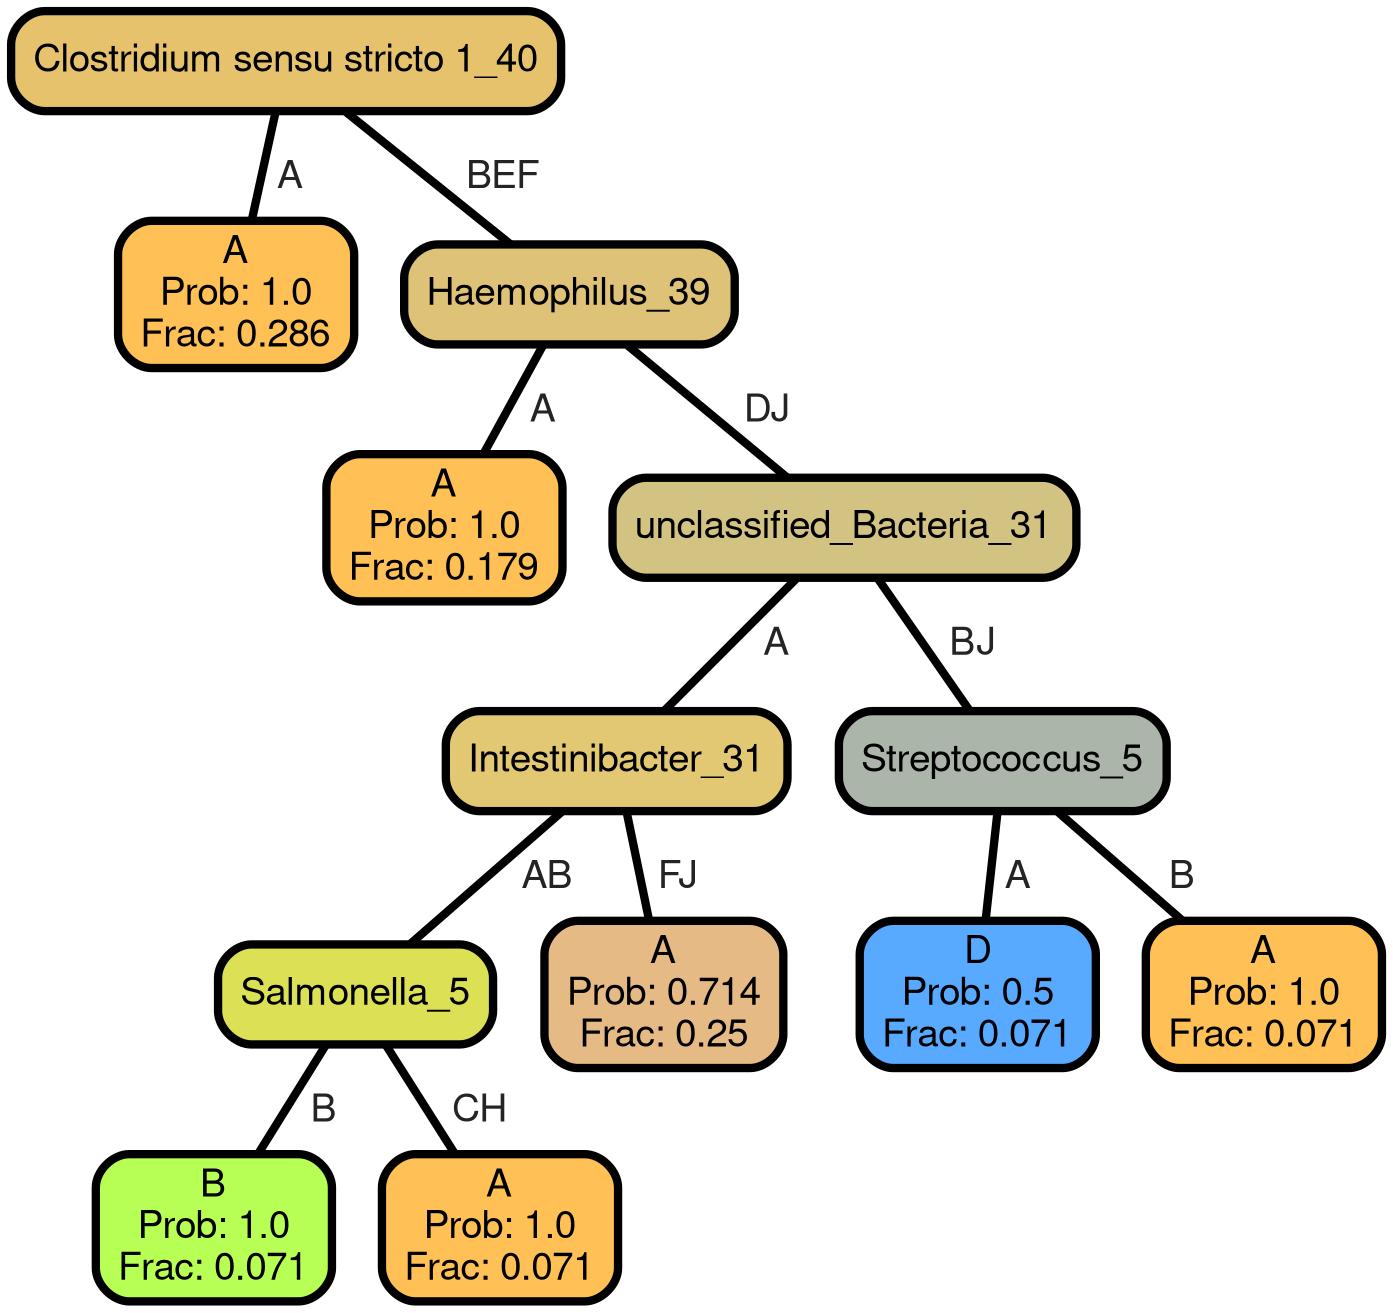

In [9]:
from IPython.display import Image
import glob
Image(filename=glob.glob(outdirname+"/*png")[0])

# Forecast microbiome evolutionary trajectories <a name="Forecast"></a>

Next, we forecast abundances from a given initial time point, using the `Forecaster()`.
Note that the `forecast_data()` method uses data in the form of a quantized numpy array (here, the `label_matrix` from above). We also specifiy the start time (start-week, SW) of the forecast time, the data before that is assumed to be known.

In [11]:
label_matrix

array([['A', '', 'E', ..., '', 'C', ''],
       ['C', '', '', ..., '', 'H', ''],
       ['', '', '', ..., '', 'B', ''],
       ...,
       ['A', 'J', '', ..., 'D', '', ''],
       ['D', '', '', ..., '', '', ''],
       ['A', '', '', ..., '', '', 'E']], dtype='<U1')

In [14]:
# forecast from time SW
SW = 9
qnet_orchestrator = QnetOrchestrator(quantizer)
qnet_orchestrator.load_qnet("example_qnet_"+base_tax+".pkl.gz",GZIP=True)
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(label_matrix, start_week=SW).assign(
    source="forecasted"
)

The result is a long-form data frame of relative abundances for each subject. 

In [15]:
DF = forecasted_
SUBJECTS = DF.subject_id.value_counts().index.values
DF

DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

For comparison, we plot the forecasted vs. actual data (averaged over all subjects):

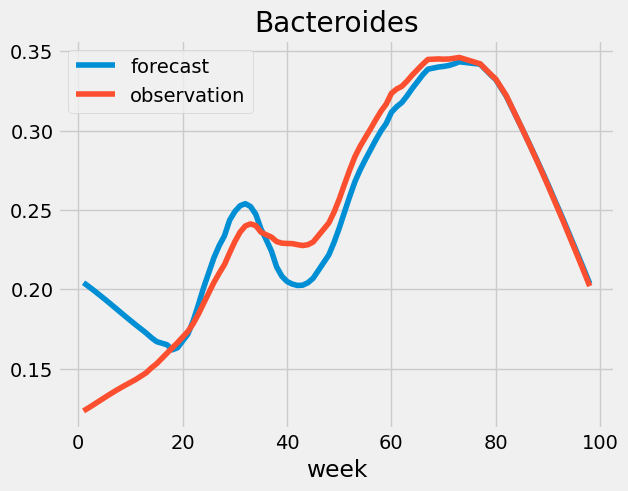

In [16]:
DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

ax = DF_pop_smooth[biome].plot(label="forecast")
DF_data_smooth[biome].plot(ax=ax, label="observation")
ax.set_title(biome)
ax.legend()

Here is a comparison plot for an individual subject:

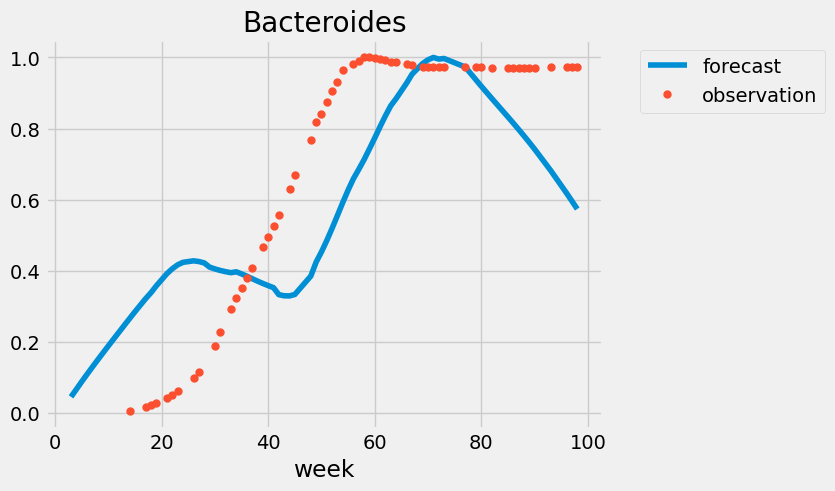

In [17]:
SID = "11"
DF_pop = (
    DF[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_data = (
    data[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.4,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.6,
)

var = biome
ax = DF_pop_smooth[var].plot(label="forecast")
DF_data_smooth[var].plot(ax=ax, style="o", ms=5, label="observation")
ax.set_title(biome)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

## Generate Ecosystem Evolution for a Non-existant "Phantom" Patient <a name="Phantom_Patient"></a>

If we want to forecast the trajectory of a new subject, we just read in their data, quantize, and forecast. 
We can also do this forecast for a "phantom" subject, one which does not actually exist, but is a realistic simulation of a possible patient or subjecty. This phantom patient is initialized with  some random observations or even no observations for any of the taxa at any of the weeks.

Here we demonstrate by randomly generating a "phantom" subject and forecasting from week SW.

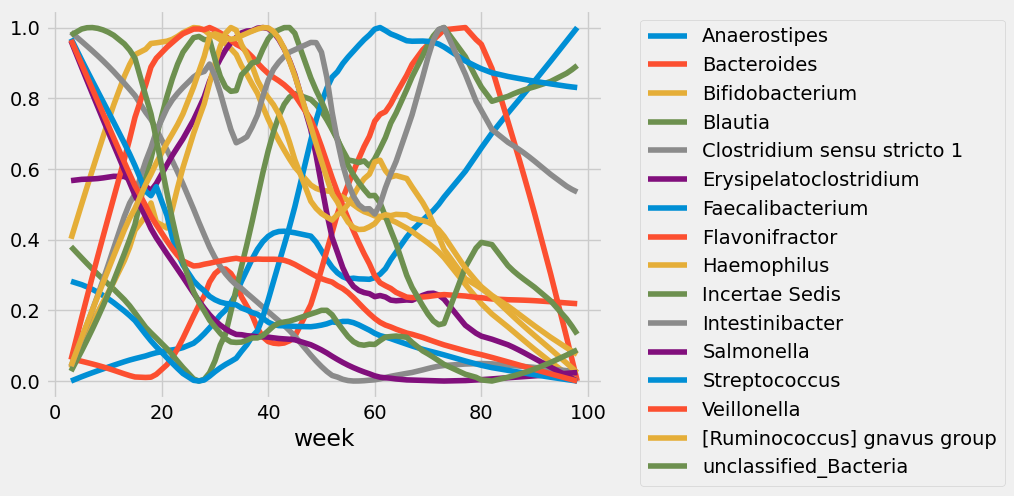

In [18]:
new_subject = pd.DataFrame(
    {
        "week": [0] * len(TAXA),
        "variable": TAXA,
        "value": [np.nan]*len(TAXA),
    }
)
new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=SW, subject_id=[12345]
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.3,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

### Only predict 40 weeks and later, when we have a profile observed at 20 weeks

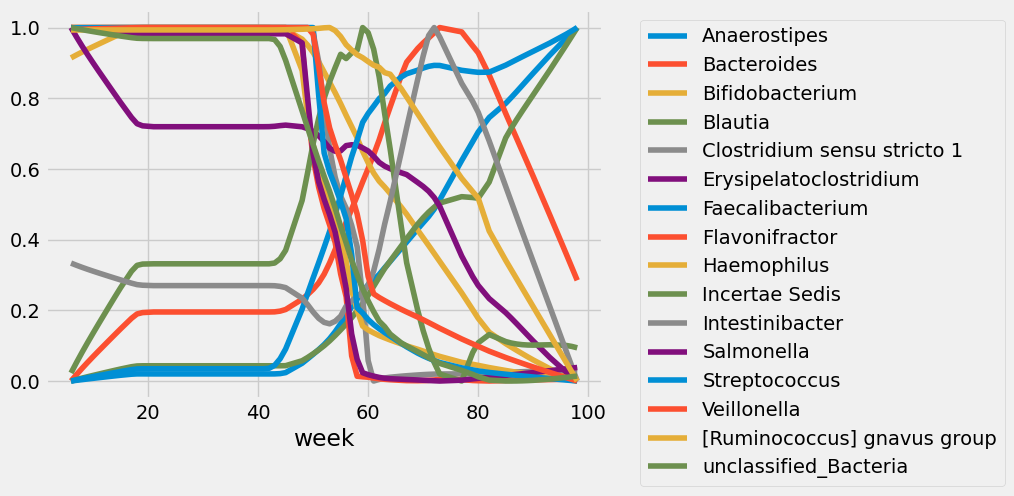

In [19]:
new_subject = pd.DataFrame(
    {
        "week": [20] * len(TAXA),
        "variable": TAXA,
        "value": np.random.rand(len(TAXA)),
    }
)


new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data( 
    new_subject_matrix, start_week=SW+40, subject_id=[12345], n_samples=50
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.3,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Complexity of Inferred Digital Twin <a name="Complexity"></a>

There are many different methods of ideas to measure complexity. One apprach is to note the number of independent trainable parameters. This is adaptive for the Qnet since the individual tree deptsh are automatically identified.

In [20]:
from quasinet.utils import numparameters
numparameters(model)

10271

In [21]:
new_subject = pd.DataFrame(
    {
        "week": [20] * len(TAXA),
        "variable": TAXA,
        "value": np.random.rand(len(TAXA)),
    }
)


new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)


In [22]:
new_subject_matrix

array([['', '', '', ..., '', '', '']], dtype='<U1')

In [23]:
from quasinet.qsampling import qsample
qsample(label_matrix[0],model,steps=1000)

array(['A', 'I', 'E', ..., 'I', 'I', 'E'], dtype='<U1')

In [24]:
label_matrix

array([['A', '', 'E', ..., '', 'C', ''],
       ['C', '', '', ..., '', 'H', ''],
       ['', '', '', ..., '', 'B', ''],
       ...,
       ['A', 'J', '', ..., 'D', '', ''],
       ['D', '', '', ..., '', '', ''],
       ['A', '', '', ..., '', '', 'E']], dtype='<U1')

In [25]:
! cp /home/ishanu/Dropbox/H.dat .

In [26]:
! /home/ishanu/Dropbox/ZED/Research/data_smashing_/bin/embed -f H.dat


 88.105637s wall, 966.050000s user + 1.140000s system = 967.190000s CPU (1097.8%)


In [27]:
! ls -lhtr

total 68M
-rw-r--r--. 1 ishanu ishanu  470 Apr 10 17:12 README.md
drwxr-xr-x. 7 ishanu ishanu 4.0K Apr 10 17:13 publication_examples
drwxr-xr-x. 4 ishanu ishanu 4.0K Apr 10 17:13 example_data
-rw-r--r--. 1 ishanu ishanu 467K Apr 11 07:38 basic-example.ipynb
-rw-r--r--. 1 ishanu ishanu 7.5M Apr 11 07:39 example_qnet_Genus.pkl.gz
-rw-r--r--. 1 ishanu ishanu 1.5K Apr 11 07:40 getLink.py
drwxr-xr-x. 2 ishanu ishanu  20K Apr 11 07:43 trees_family
-rw-r--r--. 1 ishanu ishanu   93 Apr 11 21:09 plotNetwork.py
-rw-r--r--. 1 ishanu ishanu 272K Apr 11 21:09 network.png
-rw-r--r--. 1 ishanu ishanu 6.0K Apr 11 21:09 getNetworkPlot_biome.py
-rw-r--r--. 1 ishanu ishanu 7.7M Apr 11 21:09 example_qnet_Order.pkl.gz
-rw-r--r--. 1 ishanu ishanu 8.0M Apr 11 21:09 example_qnet_Family.pkl.gz
-rw-r--r--. 1 ishanu ishanu 4.7M Apr 11 21:09 example_qnet_Class.pkl.gz
drwxr-xr-x. 2 ishanu ishanu  12K Apr 11 21:10 trees_Class
drwxr-xr-x. 2 ishanu ishanu  20K Apr 11 21:11 trees_Order
-rw-r--r--. 1 ishanu ishanu 4.0K

In [28]:
E=pd.read_csv('outE.txt',sep=' ',header=None).T.dropna(how='all')
E.columns=['x'+str(i) for i in E.columns]
E.to_csv('E.csv',index=None,header=None,sep=' ')

In [29]:
E_=pd.concat([E.iloc[(i-1)*20:20*i,:2].assign(num=i) for i in range(45)])

In [30]:
m=2
E_=pd.concat([E.iloc[(i-1)*20:20*i,:m].assign(num=i) for i in range(45)])

X=pd.concat([pd.DataFrame(E_[E_.num==i+1].drop('num',axis=1).values.reshape(1,20*m).squeeze()).T for i in range(44)])

In [90]:
from sklearn.neighbors import KernelDensity
N=300
x0_range = np.linspace(E['x0'].min(), E['x0'].max(), N)
x1_range = np.linspace(E['x1'].min(), E['x1'].max(), N)
#x2_range = np.linspace(E['x2'].min(), E['x2'].max(), N)
X0, X1= np.meshgrid(x0_range, x1_range)#,x2_range)
xy = np.vstack([X0.ravel(), X1.ravel()]).T#, X2.ravel()]).T
kde = KernelDensity(
        bandwidth=0.0004, metric="euclidean", kernel="gaussian", algorithm="ball_tree"
    )
kde.fit(E[['x0','x1']])#,'x2']])
Z_ = np.exp(kde.score_samples(xy))
Z=Z_.reshape(X1.shape)

<Axes: xlabel='x0', ylabel='x1'>

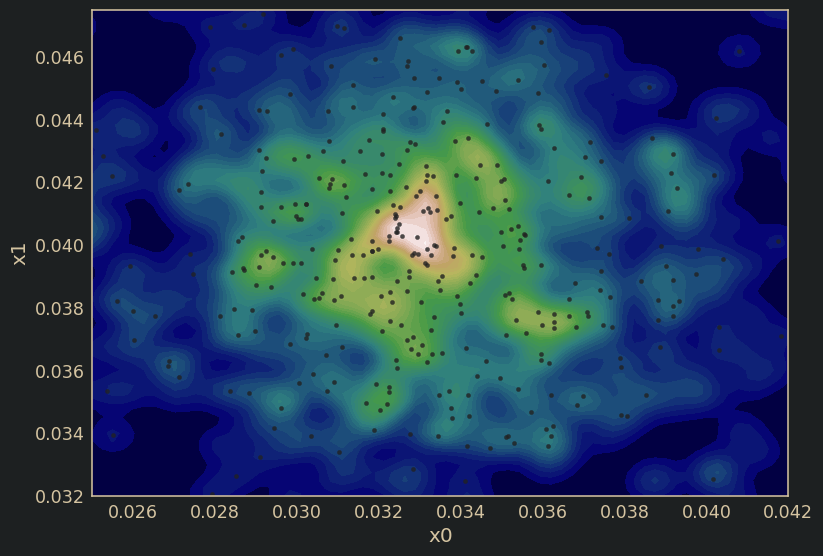

In [95]:
from jupyterthemes import jtplot
jtplot.style()
plt.figure(figsize=(8, 6))
ax=plt.gca()
plt.contourf(X0, X1, Z, levels=40, cmap=plt.cm.gist_earth)
plt.gca().set_xlim(0.025,0.042)
plt.gca().set_ylim(0.032,0.0475)
E_.sample(400).plot.scatter(ax=ax,x='x0',y='x1',color='k',alpha=.8,s=10)


In [89]:
Z_

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
H=pd.read_csv('H.dat',header=None,sep=' ')

In [67]:
def invert_distance_matrix(df, small_value_threshold=1e-5):
    """
    Inverts a DataFrame of distance values, setting small or infinite values to zero.
    
    Parameters:
    - df (pandas.DataFrame): DataFrame containing distance values.
    - small_value_threshold (float): Threshold below which inverted values are set to zero.
    
    Returns:
    - pandas.DataFrame: DataFrame with inverted distance values.
    """
    # Invert the distance values
    inverted_df = 1.0 / df.replace(0, np.inf)  # Replace zeros with inf to avoid division by zero

    # Set small or infinite values to zero
    inverted_df[np.isinf(inverted_df) | (inverted_df < small_value_threshold)] = 0

    return inverted_df

H_=invert_distance_matrix(H, small_value_threshold=19)
H_

,0,1,2,3,4,5,6,7,8,9,...,870,871,872,873,874,875,876,877,878,879
0,0.000000,0.0,0.0,20.708547,20.227426,19.897832,0.0,20.076997,0.0,0.0,...,20.315606,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,19.910519,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,20.708547,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,20.586098,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,20.227426,0.0,0.0,0.000000,0.000000,20.201232,0.0,20.426491,0.0,0.0,...,24.159011,0.000000,0.0,19.592731,0.000000,19.388773,0.0,0.0,0.0,19.469003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.000000,0.0,0.0,0.000000,19.388773,0.000000,0.0,0.000000,0.0,0.0,...,21.056155,0.000000,0.0,21.405717,19.369118,0.000000,0.0,0.0,0.0,0.000000
876,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,22.259835,20.168695,0.0,19.432478,0.000000,0.000000,0.0,0.0,0.0,0.000000
877,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,19.943310,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
878,0.000000,0.0,0.0,0.000000,0.000000,20.312262,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [68]:
import networkx as nx
G = nx.Graph()
n = len(H)  # Number of nodes
for i in range(n):
    for j in range(i + 1, n):
        if H_[i][j] != 0:#np.inf:
            G.add_edge(i, j, weight=H_[i][j])
mst = nx.minimum_spanning_tree(G, algorithm='kruskal')
# Function to draw the graph and MST with labels

In [69]:
import matplotlib.pyplot as plt
def draw_graph(graph, pos, mst=None):
    # Draw the graph
    nx.draw_networkx_nodes(graph, pos, node_size=7, node_color='lightblue')
    nx.draw_networkx_edges(graph, pos, alpha=0.3, width=3)
    #nx.draw_networkx_labels(graph, pos, font_size=12, font_family='sans-serif')
    
    if mst:
        # Draw the MST with distinct color and labels
        nx.draw_networkx_edges(
            graph, pos,
            edgelist=mst.edges(),
            width=.5, edge_color='green', style='dashed'
        )

    plt.show()

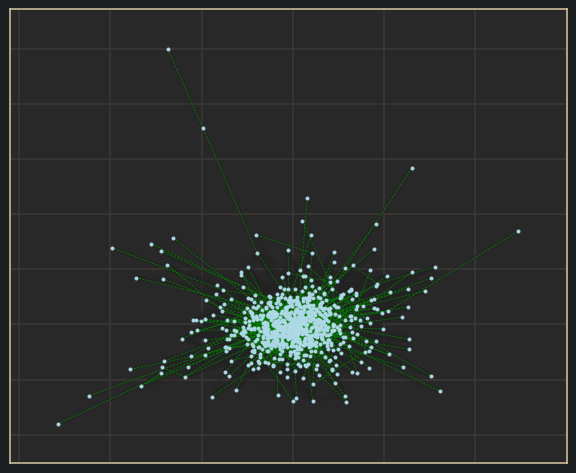

Edges in MST with weights:
0 - 552 with weight 19.013657705192553
3 - 203 with weight 19.012519858141253
4 - 192 with weight 19.006129365623657
4 - 97 with weight 19.009987514552627
5 - 278 with weight 19.009333178237817
7 - 746 with weight 19.001733735723604
7 - 338 with weight 19.01039706163769
16 - 431 with weight 19.008148515107553
16 - 855 with weight 19.008268027217216
21 - 494 with weight 19.005455065734157
21 - 355 with weight 19.00739786188338
21 - 251 with weight 19.007554096786052
21 - 357 with weight 19.009387776456148
30 - 68 with weight 19.001491543809696
30 - 181 with weight 19.00424687008927
30 - 110 with weight 19.00579566961496
31 - 573 with weight 19.002311460621524
31 - 473 with weight 19.005233786215577
31 - 754 with weight 19.008963057055528
44 - 174 with weight 19.0327943682702
45 - 122 with weight 19.007232402757552
48 - 34 with weight 19.000538965453355
49 - 276 with weight 19.00403299086948
49 - 838 with weight 19.007080975460756
49 - 710 with weight 19.007536

In [70]:
pos = nx.spring_layout(G)

# Draw the graph and MST
draw_graph(G, pos, mst)

# Output the MST edges and weights
print("Edges in MST with weights:")
for u, v, data in mst.edges(data=True):
    print(f"{u} - {v} with weight {data['weight']}")

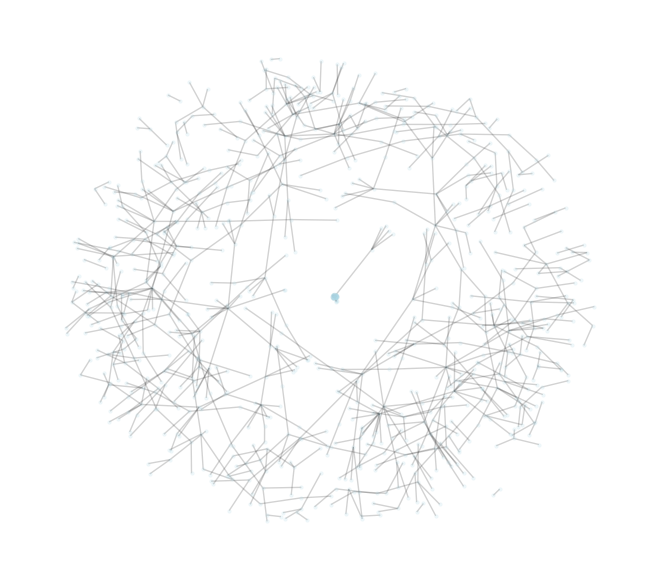

In [86]:
H1=H[H<.05].fillna(100)
def create_knn_graph(df, k):
    """
    Creates a graph where each node is connected to its K nearest neighbors.
    
    Parameters:
    - df (pandas.DataFrame): DataFrame containing the distance matrix.
    - k (int): Number of nearest neighbors to connect each node to.
    
    Returns:
    - networkx.Graph: The resulting graph with K-nearest neighbor edges.
    """
    # Initialize an empty graph
    G = nx.Graph()
    
    # Iterate over each row in the DataFrame
    for i, distances in df.iterrows():
        # Get the indices of the K smallest distances
        # Use argsort to get indices of sorted items and slice for K items
        # We add 1 because argsort will include the node itself (distance 0)
        indices = np.argsort(distances)[1:k+1]
        
        # Add edges from this node to its K-nearest neighbors
        for index in indices:
            # Add an edge only if not already added (since this is an undirected graph)
            if not G.has_edge(i, index):
                G.add_edge(i, index, weight=distances[index])

    return G

# Example usage:

df_distances = H1

# Create the K-nearest neighbors graph (K=2 for this example)
G = create_knn_graph(df_distances, 1)

# You can visualize the graph using NetworkX and Matplotlib (optional)
import matplotlib.pyplot as plt
#nx.draw_networkx_nodes(G, pos, node_size=7, node_color='lightblue')
#nx.draw_networkx_edges(G, pos, alpha=0.3, width=3)
nx.draw(G, font_weight='bold',node_size=7, alpha=.2,node_color='lightblue')
plt.show()

In [84]:
H1

,0,1,2,3,4,5,6,7,8,9,...,870,871,872,873,874,875,876,877,878,879
0,0.000000,100.0,100.0,0.048289,0.049438,100.000000,100.0,0.049808,100.0,100.0,...,0.049223,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
1,100.000000,0.0,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,...,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
2,100.000000,100.0,0.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,...,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
3,0.048289,100.0,100.0,0.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,...,0.048576,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
4,0.049438,100.0,100.0,100.000000,0.000000,0.049502,100.0,0.048956,100.0,100.0,...,0.041392,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,...,0.047492,100.000000,100.0,0.046716,100.0,0.0,100.0,100.0,100.0,100.0
876,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,...,0.044924,0.049582,100.0,100.000000,100.0,100.0,0.0,100.0,100.0,100.0
877,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.0,...,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,0.0,100.0,100.0
878,100.000000,100.0,100.0,100.000000,100.000000,0.049231,100.0,100.000000,100.0,100.0,...,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,0.0,100.0


In [79]:
H

,0,1,2,3,4,5,6,7,8,9,...,870,871,872,873,874,875,876,877,878,879
0,0.000000,0.057263,0.053009,0.048289,0.049438,0.050257,0.067231,0.049808,0.059254,0.053520,...,0.049223,0.059875,0.063661,0.056098,0.056955,0.055220,0.056478,0.055771,0.058558,0.054948
1,0.057263,0.000000,0.059600,0.056075,0.056244,0.053823,0.062902,0.055333,0.057273,0.056040,...,0.050225,0.054958,0.058502,0.056941,0.052647,0.057198,0.055782,0.060751,0.060484,0.058437
2,0.053009,0.059600,0.000000,0.055166,0.058779,0.053124,0.063826,0.061131,0.058818,0.054366,...,0.054742,0.059944,0.058805,0.058582,0.060155,0.054212,0.056227,0.056044,0.054626,0.057406
3,0.048289,0.056075,0.055166,0.000000,0.056629,0.052633,0.062430,0.058379,0.059629,0.057372,...,0.048576,0.056039,0.062653,0.057154,0.056128,0.055804,0.054573,0.057156,0.057392,0.053260
4,0.049438,0.056244,0.058779,0.056629,0.000000,0.049502,0.060788,0.048956,0.059841,0.052903,...,0.041392,0.056505,0.060302,0.051039,0.052993,0.051576,0.052708,0.056179,0.054377,0.051364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,0.055220,0.057198,0.054212,0.055804,0.051576,0.052956,0.061213,0.054414,0.058987,0.055809,...,0.047492,0.061542,0.053199,0.046716,0.051629,0.000000,0.053050,0.055311,0.059472,0.058720
876,0.056478,0.055782,0.056227,0.054573,0.052708,0.059649,0.062799,0.057774,0.060521,0.055552,...,0.044924,0.049582,0.059268,0.051460,0.054437,0.053050,0.000000,0.056663,0.058928,0.054380
877,0.055771,0.060751,0.056044,0.057156,0.056179,0.055775,0.068324,0.057640,0.061284,0.057112,...,0.050142,0.057632,0.058804,0.053454,0.056737,0.055311,0.056663,0.000000,0.055691,0.057040
878,0.058558,0.060484,0.054626,0.057392,0.054377,0.049231,0.058286,0.055098,0.062711,0.056480,...,0.053915,0.058892,0.059561,0.055520,0.059669,0.059472,0.058928,0.055691,0.000000,0.053790
